105 ns ± 0.00508 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


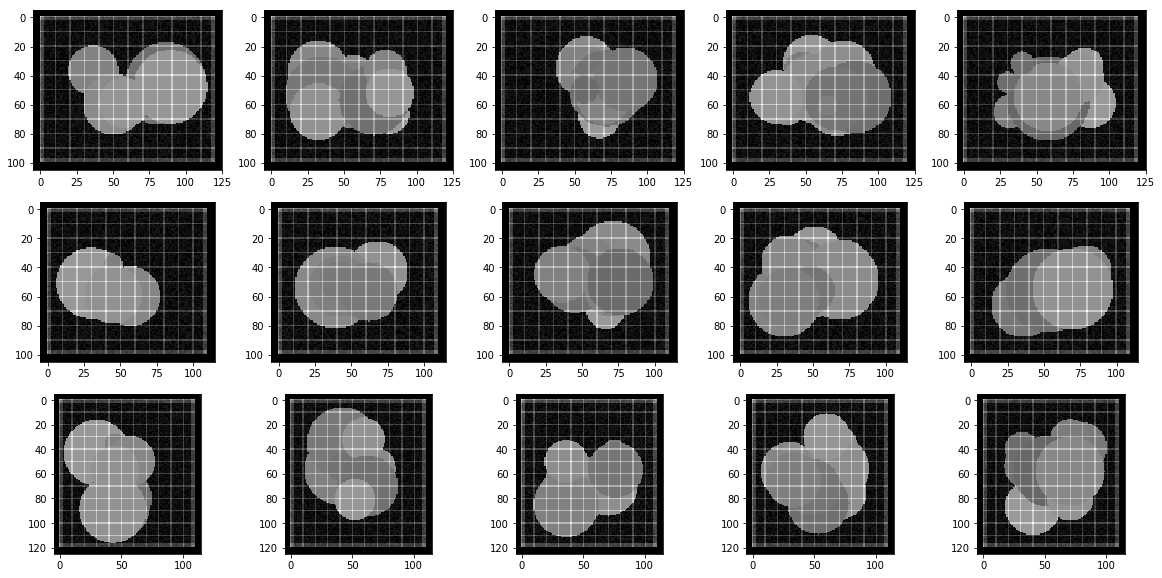

In [64]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob, time
from collections import OrderedDict
from functools import partial
import numpy as np

from PIL import Image

#from scipy.interpolate import interp2d, RectBivariateSpline,griddata
#from scipy.ndimage import zoom, geometric_transform
#from scipy.ndimage.filters import gaussian_filter
#from scipy.ndimage.interpolation import map_coordinates
#import cv2

#from skimage.transform import PiecewiseAffineTransform, warp, PolynomialTransform
#from skimage import data

import matplotlib.pyplot as plt

#import SimpleITK as sitk

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

imwidth = 100
imheight = 120
imdepth=110
numimgs = 5

def createTestImage(width, height, depth, numObjs=12, radMax=30):
    '''Return a noisy 3D image with `num_objs' circles and a 3D mask image.'''
    image = np.zeros((width, height, depth))

    for i in range(numObjs):
        x = np.random.randint(radMax, width - radMax)
        y = np.random.randint(radMax, height - radMax)
        z = np.random.randint(radMax, depth - radMax)
        rad = np.random.randint(10, radMax)
        
        spy, spx, spz = np.ogrid[-x:width - x, -y:height - y,-z:depth-z]
        sphere = (spx * spx + spy * spy + spz * spz) <= rad * rad
        image[sphere] = np.random.random() * 0.5 + 0.5

    norm = np.random.uniform(0, 0.25, size=image.shape)

    return np.maximum(image, norm), (image > 0).astype(np.int32) 


imagemaskpairs=[createTestImage(imwidth,imheight,imdepth) for _ in range(numimgs)]
    
    
def testAugment(aug):
    '''Time the augmentation function `aug' and draw its results in XY, XZ, and YZ planes with grid lines.'''
    
    %timeit aug(*imagemaskpairs[0])
    fig,ax=plt.subplots(3,numimgs,figsize=(20,10))

    for i in range(numimgs):
        def axshow(ind,im):
            ax[ind,i].axis('on')
            ax[ind,i].imshow(im)
            ax[ind,i].axis((-5, im.shape[1]+5, im.shape[0]+5, -5))
            ax[ind,i].set_facecolor('black')
            
        img,mask=imagemaskpairs[i]
        img=img.copy()
        
        # draw grid
        img[::10,:,:]+=0.5
        img[:,::10,:]+=0.5
        img[:,:,::10]+=0.5

        # draw border
        img[:,:, :3]+=0.5
        img[:,:,-3:]+=0.5
        img[:, :3,:]+=0.5
        img[:,-3:,:]+=0.5
        img[ :3,:,:]+=0.5
        img[-3:,:,:]+=0.5
        
        img,mask=aug(img,mask)

        axshow(0,img[:,:,imdepth//2]+mask[:,:,imdepth//2]*0.5)
        axshow(1,img[:,imdepth//2,:]+mask[:,imdepth//2,:]*0.5)
        axshow(2,img[imdepth//2,:,:]+mask[imdepth//2,:,:]*0.5)
        
        
testAugment(lambda i,m:(i,m)) # test run with a null-deformation

2.91 s ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


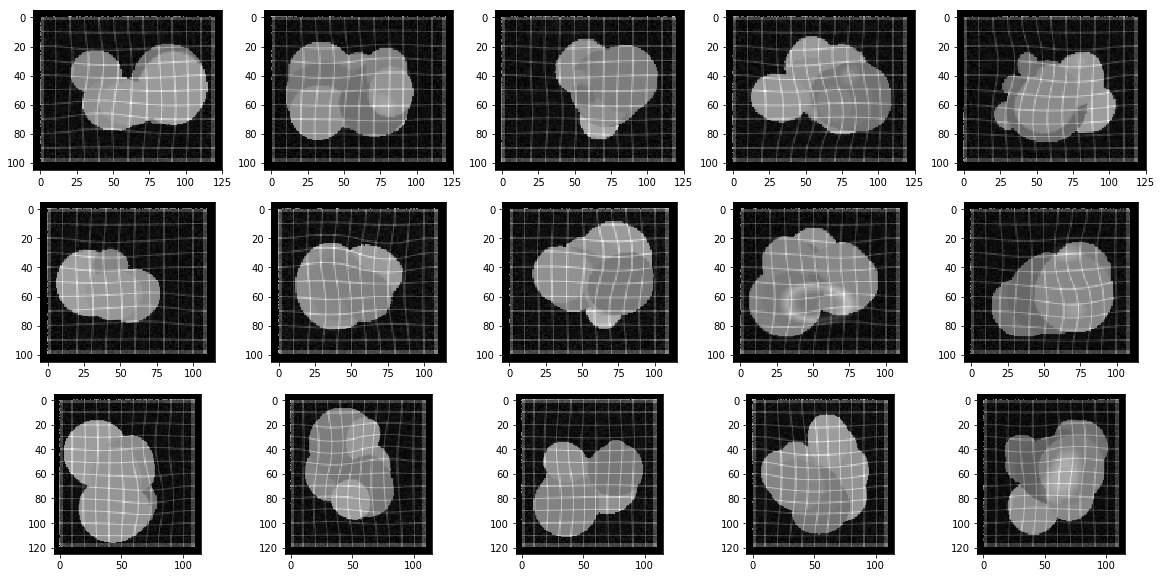

In [67]:
from scipy.ndimage import zoom

def deformBothAugment3D(image,mask,defrange=5,numControls=2,margin=1,zoomOrder=2):
    inshape=image.shape
    h,w,d = inshape
    ctrls=numControls+margin*2
    
    # start by defining a small 4D volume of deformation values, last dimension is the XYZ vector components
    imshift=np.zeros((ctrls,ctrls,ctrls,3))
    # randomly assign values in the inner portion of the volume, leaving the edges 0
    imshift[margin:-margin,margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(numControls,numControls,numControls,3))
    # now resize the volume to the size of the input, this will smoothly interpolate the assigned values above to create a smooth uniform deformation field
    imshift=zoom(imshift,(h/ctrls,w/ctrls,d/ctrls,1),order=zoomOrder)

    # break the XYZ components up for convenience
    imshifty=imshift[...,0]
    imshiftx=imshift[...,1]
    imshiftz=imshift[...,2]
        
    # define coordinate indices 
    y,x,z= np.meshgrid(np.arange(w), np.arange(h), np.arange(d))
    indices =  np.reshape(x+imshiftx, (-1, 1)), np.reshape(y+imshifty, (-1, 1)),np.reshape(z+imshiftz, (-1, 1))
    
    distorted_image = map_coordinates(image, indices, order=1, mode='constant')
    distorted_mask = map_coordinates(mask, indices, order=1, mode='constant')

    return distorted_image.reshape(inshape),distorted_mask.reshape(inshape)


testAugment(lambda i,m: deformBothAugment3D(i,m))

643 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


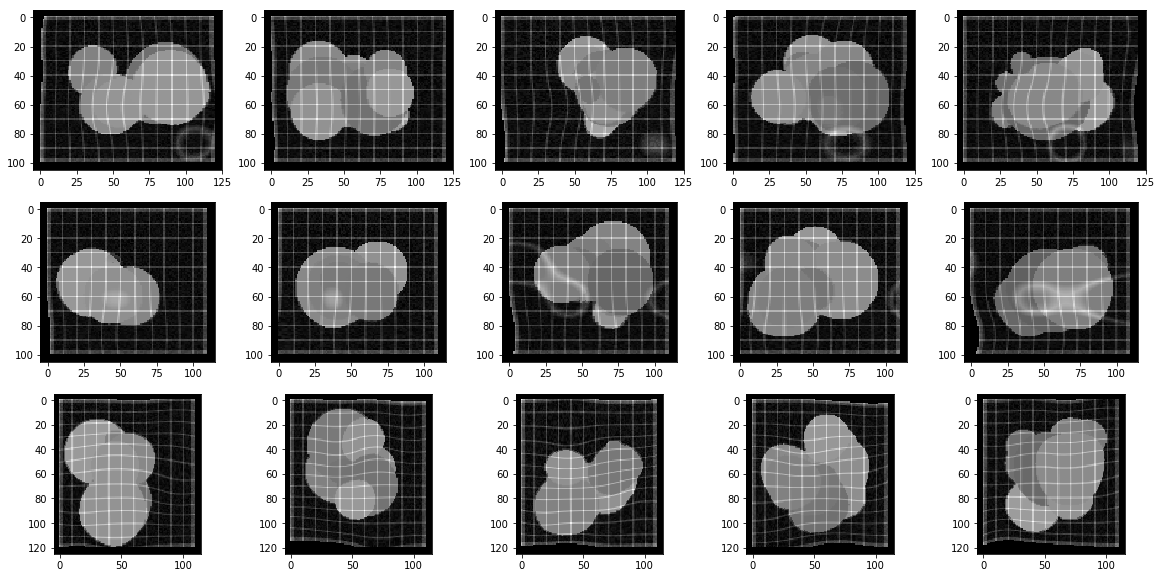

In [79]:
import SimpleITK as sitk
resample = sitk.ResampleImageFilter()

def deformBothAugmentSitk(image,mask,defrange=20,numSplines=4,order=2):
    dimension=image.ndim
    numControls=numSplines+order*2

    # start by defining a small 4D volume of deformation values, last dimension is the XYZ vector components
    imshift=np.zeros((3,numControls,numControls,numControls))
    # randomly assign values in the inner portion of the volume, leaving the edges 0
    imshift[:,order:-order,order:-order,order:-order]=np.random.randint(-defrange,defrange,(3,numSplines,numSplines,numSplines))

    im=sitk.GetImageFromArray(image)
    ma=sitk.GetImageFromArray(mask)

    bspline=sitk.BSplineTransformInitializer(im,[numSplines,numSplines,numSplines],order)
    bspline.SetParameters(imshift.flatten())
    resample.SetReferenceImage(im)
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(0)
    resample.SetTransform(bspline)
    
    image=sitk.GetArrayFromImage(resample.Execute(im))
    mask=sitk.GetArrayFromImage(resample.Execute(ma))
    
    return image,mask


testAugment(lambda i,m:deformBothAugmentSitk(i,m))